# LBA - CS146

## Data processing

In [42]:
import pystan

I removed the data collected by the following students because they either don't reside in Berlin or the neighborhood can't be determined: Barbara, Erika Sloan, Evan Buckman, Frances Pak Gelana Tostaeva, Hana Mcmahon-Cole, Jingren Wang, Mandla, Michelle Hackl, Nikesh Shrestha,, Sara Merner, Vu chu, Vy, Vu Luong.


In [105]:
import csv
location_map = {'Alt-Treptow': 1,
 'Friedrichshain':2,
 'Kreuzberg':3,
 'Lichtenberg':4,
 'Mitte':5,
 'Neukölln':6,
 'Prenzlauer Berg':7,
 'Schöneberg':8,
 'Tempelhof':9}
inverse_location_map = {1:'Alt-Treptow',
 2:'Friedrichshain',
 3:'Kreuzberg',
 4:'Lichtenberg',
 5:'Mitte',
 6:'Neukölln',
 7:'Prenzlauer Berg',
 8:'Schöneberg',
 9:'Tempelhof'}
brand_map = {'ALDI':1 , 'EDEKA':2, 'Lidl':3, 'REWE':4}
inverse_brand_map = {1:'ALDI' , 2:'EDEKA', 3:'Lidl', 4:'REWE'}
brand = []
location = []
item_type = [] # 'apples', 'bananas', tomatoes', 'potatoes', 
                # 'flour', 'rice', 'milk', 'butter', 'eggs', 'chicken breasts'
item_map = {1:'apples', 2:'bananas', 3:'tomatoes',4: 'potatoes', 
                5:'flour', 6:'rice', 7:'milk', 8:'butter', 9:'eggs' , 10:'chicken breasts'}
price = []
with open('raw_lba.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None)
    line_count = 0
    for row in csv_reader:
#         print('row:', row)
        for i in range(1,11): # 10 items
            data_list_for_this_item = [row[5+6*(i-1)+j] for j in range(1,7)]
            # product 1
            if data_list_for_this_item[0] != '' and data_list_for_this_item[1] != '':
                brand.append(brand_map[row[3]])
                item_type.append(i)
                location.append(location_map[row[4]])
                price.append(float(data_list_for_this_item[1])/float(data_list_for_this_item[0]))
            # product 2
            if data_list_for_this_item[2] != '' and data_list_for_this_item[3] != '':
                brand.append(brand_map[row[3]])
                item_type.append(i)
                location.append(location_map[row[4]])
                price.append(float(data_list_for_this_item[3])/float(data_list_for_this_item[2]))
            # product 3
            if data_list_for_this_item[4] != '' and data_list_for_this_item[5] != '':
                brand.append(brand_map[row[3]])
                item_type.append(i)
                location.append(location_map[row[4]])
                price.append(float(data_list_for_this_item[5])/float(data_list_for_this_item[4]))       

In [73]:
# demo what all the code above is
for i in range(30):
    print('Item:', item_type[i], 'Neighborhood:', location[i], 'Store:', brand[i], 'price:', price[i])

Item: 1 Neighborhood: 3 Store: 2 price: 2.49
Item: 1 Neighborhood: 3 Store: 2 price: 2.49
Item: 1 Neighborhood: 3 Store: 2 price: 1.66
Item: 2 Neighborhood: 3 Store: 2 price: 5.2
Item: 2 Neighborhood: 3 Store: 2 price: 2.99
Item: 2 Neighborhood: 3 Store: 2 price: 1.09
Item: 3 Neighborhood: 3 Store: 2 price: 8.0
Item: 3 Neighborhood: 3 Store: 2 price: 4.98
Item: 3 Neighborhood: 3 Store: 2 price: 8.0
Item: 4 Neighborhood: 3 Store: 2 price: 2.49
Item: 4 Neighborhood: 3 Store: 2 price: 0.8
Item: 4 Neighborhood: 3 Store: 2 price: 2.49
Item: 5 Neighborhood: 3 Store: 2 price: 0.99
Item: 5 Neighborhood: 3 Store: 2 price: 1.79
Item: 5 Neighborhood: 3 Store: 2 price: 1.98
Item: 6 Neighborhood: 3 Store: 2 price: 7.16
Item: 6 Neighborhood: 3 Store: 2 price: 2.78
Item: 6 Neighborhood: 3 Store: 2 price: 5.98
Item: 7 Neighborhood: 3 Store: 2 price: 0.63
Item: 7 Neighborhood: 3 Store: 2 price: 0.71
Item: 7 Neighborhood: 3 Store: 2 price: 0.99
Item: 8 Neighborhood: 3 Store: 2 price: 1.5
Item: 8 Neighbo

# Hyperparameters Selection

In [5]:
# find hyperparameters 
from scipy.optimize import minimize
import scipy
import scipy.stats as sts
def f(x):
    alpha = x[0]
    beta = x[1]
    lower = sts.gamma(a=alpha, scale=1/beta).cdf(0.5)
    upper = sts.gamma(a=alpha, scale=1/beta).cdf(2)
    return (lower-0.025)**2 + (upper-0.975)**2 + (alpha - 1 - beta)**2
x_initial = [1,1]
result = minimize(f, x_initial)
x_final = result.x

In [2]:
x_final

array([2.76354028, 1.76354009, 0.29451489, 3.88214322])

# Model

In [74]:
# Build the stan model:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num; // number of data points
    real<lower=0> lambda1; // lambda for base price exponential prior 
    real<lower=0> lambda2; // lambda for beta exponential prior 
    int<lower=1> num_items; // number different types of items (e.g., apples, rice, etc.)
    int<lower=1> num_brands; // number different brands (e.g., ALDI, etc.)
    int<lower=1> num_locations; // number different locations (e.g., Mitte, etc.)
    real<lower=0> alpha;  // fixed prior hyperparameter for gamma
    real<lower=0> beta;   // fixed prior hyperparameter for gamma
    real<lower=0> price_dat[num]; // normalized price
    int brand_dat[num]; // brands 
    int location_dat[num]; // neighborhoods
    int item_dat[num]; // items

}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> base_price[num_items];
    real<lower=0> brand_multip[num_brands];
    real<lower=0> location_multip[num_locations];
    real<lower=0> beta_for_likelihood; // beta of gamma likelihood
    
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    base_price[num_items] ~ exponential(lambda1);
    brand_multip[num_brands] ~ gamma(alpha, beta);
    location_multip[num_locations] ~ gamma(alpha, beta);
    
    beta_for_likelihood ~ exponential(lambda2);
    for(i in 1:num) {
        price_dat[i] ~ gamma(base_price[item_dat[i]] * brand_multip[brand_dat[i]] * location_multip[location_dat[i]] * beta_for_likelihood, beta_for_likelihood);
    }
}

"""

In [65]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0c111f31f4e45d8de6c248e1582a794 NOW.


In [81]:
data = {
    'num': len(price),
    'lambda1': 0.0000001,
    'lambda2': 0.0001,
    'num_items': len(set(item_type)),
    'num_brands': len(set(brand)),
    'num_locations': len(set(location)),
    'alpha': x_final[0],
    'beta': x_final[1],
    'price_dat': price,
    'brand_dat': brand,
    'location_dat': location,
    'item_dat': item_type
}

In [82]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.

stan_results = stan_model.sampling(data=data)

# Posteriors

## base price

In [83]:
# summarize the results
print(stan_results.stansummary(pars=['base_price'], probs=[0.01, 0.99]))

Inference for Stan model: anon_model_f0c111f31f4e45d8de6c248e1582a794.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd     1%    99%  n_eff   Rhat
base_price[1]   39.78    5.12  99.11   3.16  264.8    375   1.01
base_price[2]   30.22    3.93  76.08   2.35 203.01    376   1.01
base_price[3]   61.97    8.12 157.32   4.92 413.37    375   1.01
base_price[4]   22.76    2.99  57.66    1.8 150.22    371   1.01
base_price[5]    20.7    2.71  52.42   1.61 140.26    375   1.01
base_price[6]   56.63    7.38 142.47   4.47 379.15    373   1.01
base_price[7]   22.77     3.0  58.08   1.79 150.22    375   1.01
base_price[8]   113.3   14.73 285.68   8.86 760.36    376   1.01
base_price[9]    8.43    1.06  20.85   0.66  57.09    383   1.01
base_price[10] 138.86   18.23  353.0  10.83 903.16    375   1.01

Samples were drawn using NUTS at Sat Nov  9 22:26:21 2019.
For each parameter, n_eff is a crude

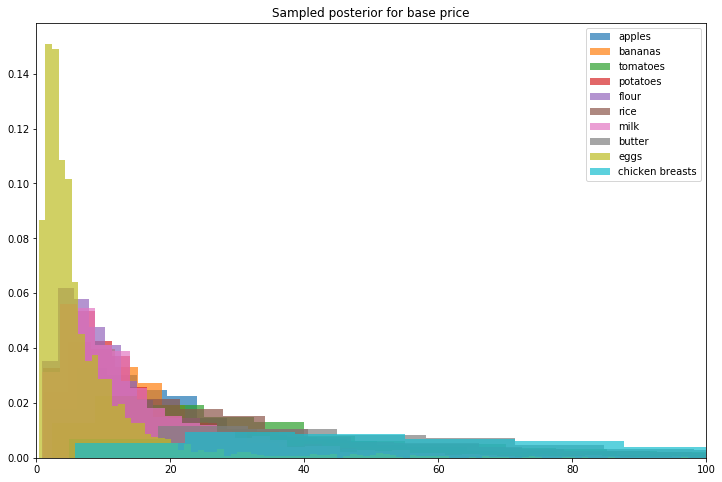

In [122]:
import matplotlib.pyplot as plt
import numpy as np
samples = stan_results.extract()

plt.figure(figsize=(12,8))
for i in range(10):
    plt.hist(samples['base_price'][:,i],bins=500, density = True, alpha = 0.7, label=item_map[i+1]) 
# plt.hist(samples['base_price'][:,0],bins=200)
# plt.hist(samples['base_price'], bins=50, density=True)
plt.title('Sampled posterior for base price')
plt.xlim(0,100)
plt.legend()
plt.show()

# print('Posterior 98% interval over lambda:', np.percentile(samples['lambda'], [1, 99]))



## Location multiplier

In [110]:
# summarize the results
print(stan_results.stansummary(pars=['location_multip'], probs=[0.01, 0.99]))

Inference for Stan model: anon_model_f0c111f31f4e45d8de6c248e1582a794.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd     1%    99%  n_eff   Rhat
location_multip[1]   0.91    0.02   0.36   0.29   1.92    534   1.01
location_multip[2]   0.79    0.01   0.32   0.25   1.68    539   1.01
location_multip[3]   0.82    0.01   0.33   0.25   1.71    543   1.01
location_multip[4]   0.84    0.01   0.33   0.26    1.8    539   1.01
location_multip[5]   0.87    0.01   0.35   0.27   1.83    538   1.01
location_multip[6]   0.84    0.01   0.34   0.26   1.76    542   1.01
location_multip[7]   0.81    0.01   0.32   0.25   1.71    539   1.01
location_multip[8]   0.83    0.01   0.33   0.26   1.77    538   1.01
location_multip[9]   0.88    0.01   0.34   0.29   1.84    535   1.01

Samples were drawn using NUTS at Sat Nov  9 22:26:21 2019.
For each parameter, n_eff is a crude measure of effective sam

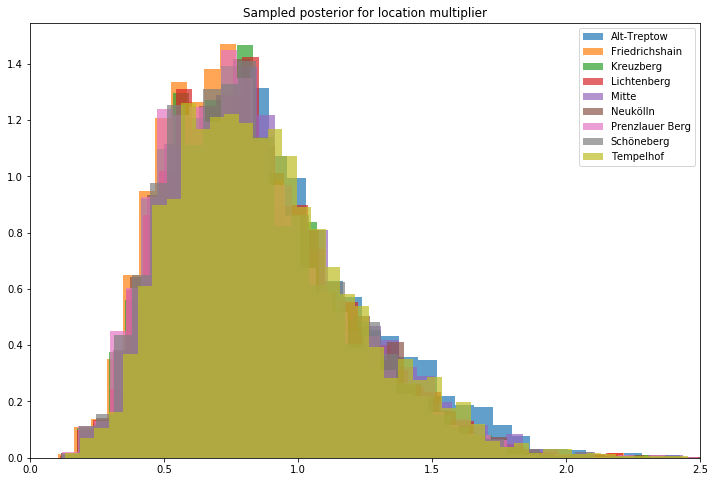

In [117]:
import matplotlib.pyplot as plt
import numpy as np
samples = stan_results.extract()

plt.figure(figsize=(12,8))
for i in range(9):
    plt.hist(samples['location_multip'][:,i],bins=50, density = True, alpha = 0.7, label=inverse_location_map[i+1]) 
# plt.hist(samples['base_price'][:,0],bins=200)
# plt.hist(samples['base_price'], bins=50, density=True)
plt.title('Sampled posterior for location multiplier')
plt.xlim(0,2.5)
plt.legend()
plt.show()

# print('Posterior 98% interval over lambda:', np.percentile(samples['lambda'], [1, 99]))




## Store brand

In [118]:
# summarize the results
print(stan_results.stansummary(pars=['brand_multip'], probs=[0.01, 0.99]))

Inference for Stan model: anon_model_f0c111f31f4e45d8de6c248e1582a794.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd     1%    99%  n_eff   Rhat
brand_multip[1]   0.18  5.9e-3   0.14   0.01   0.64    542   1.01
brand_multip[2]   0.23  7.8e-3   0.18   0.01   0.84    544   1.01
brand_multip[3]   0.17  5.8e-3   0.13   0.01   0.63    540   1.01
brand_multip[4]   0.21  6.9e-3   0.16   0.01   0.75    543   1.01

Samples were drawn using NUTS at Sat Nov  9 22:26:21 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


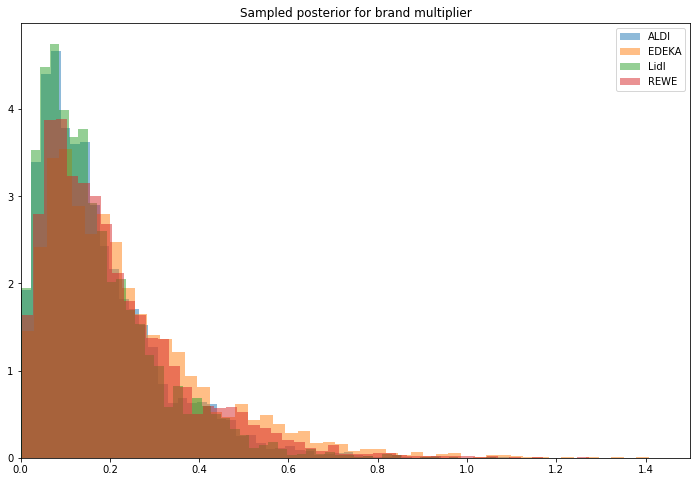

In [125]:
import matplotlib.pyplot as plt
import numpy as np
samples = stan_results.extract()

plt.figure(figsize=(12,8))
for i in range(4):
    plt.hist(samples['brand_multip'][:,i],bins=50, density = True, alpha = 0.5, label=inverse_brand_map[i+1]) 
# plt.hist(samples['base_price'][:,0],bins=200)
# plt.hist(samples['base_price'], bins=50, density=True)
plt.title('Sampled posterior for brand multiplier')
plt.xlim(0,1.5)
plt.legend()
plt.show()

# print('Posterior 98% interval over lambda:', np.percentile(samples['lambda'], [1, 99]))




# Correlation with rental prices

In [132]:
rental_prices_dict = {'Alt-Treptow': [530, 645, 782, 726, 630, 737, 773],
 'Friedrichshain':[895],
 'Kreuzberg':[865, 908],
 'Lichtenberg':[739, 736, 752, 809, 734, 649, 483, 601,588, 571, 576, 609, 587],
 'Mitte': [741, 886,893,932,957,1154,1044,1048],
 'Neukölln':[897, 844,1005,934,755,812,705,743,820,730,778,641,678,633,621,611],
 'Prenzlauer Berg':[719,902, 999],
 'Schöneberg':[817,879,860,900,884,884,855],
 'Tempelhof':[844,797,808,701,703,629,609]}
rental_prices = []
location_multip_means = []
for key in rental_prices_dict:
    rental_prices.append(np.mean(rental_prices_dict[key]))
    
    location_multip_means.append(np.mean(samples['location_multip'][:,location_map[key]-1]))


Coefficients: 
 [-0.00017553]
Intercept:
 0.9875350509976513


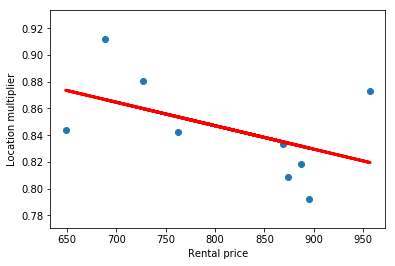

In [133]:
from sklearn import datasets, linear_model
rental_prices = [[rental_price] for rental_price in rental_prices] 
regr = linear_model.LinearRegression()

# Train the model using the training set
regr.fit(rental_prices, location_multip_means)

# Make predictions on training set
location_multip_means_preds = regr.predict(rental_prices)

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept:\n', regr.intercept_)
# # The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(bases, base_preds))

# Plot outputs

plt.scatter(rental_prices, location_multip_means)
plt.plot(rental_prices, location_multip_means_preds ,color='red', linewidth=3)
plt.xlabel('Rental price')
plt.ylabel('Location multiplier')
plt.show()